<a href="https://colab.research.google.com/github/AnaghDeshpande/Hackaphasia/blob/main/oil_spills_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

%matplotlib inline

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(12,8)

In [20]:
data=pd.read_csv('/content/oil-spill.csv')

# data.columns = [f"f_{i}" for i in range(1, 49)]
new_column_names = {data.columns[i]: f"f_{i+1}" for i in range(49)}

# Rename the columns
data.rename(columns=new_column_names, inplace=True)
data['target'] = data.iloc[:,-1]
data.drop(columns=data.columns[-2],inplace=True)
data.head()

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,target
0,2,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,...,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
1,3,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,...,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
2,4,1201,1562.53,295.65,66,3002500.0,42.40,7.97,18030.0,0.19,...,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
3,5,312,950.27,440.86,37,780000.0,41.43,7.03,3350.0,0.17,...,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0
4,6,54,1438.13,544.91,82,135000.0,44.67,6.92,1570.0,0.15,...,608.28,200.00,150.00,52.22,4.06,0,30967.25,65.77,7.85,1


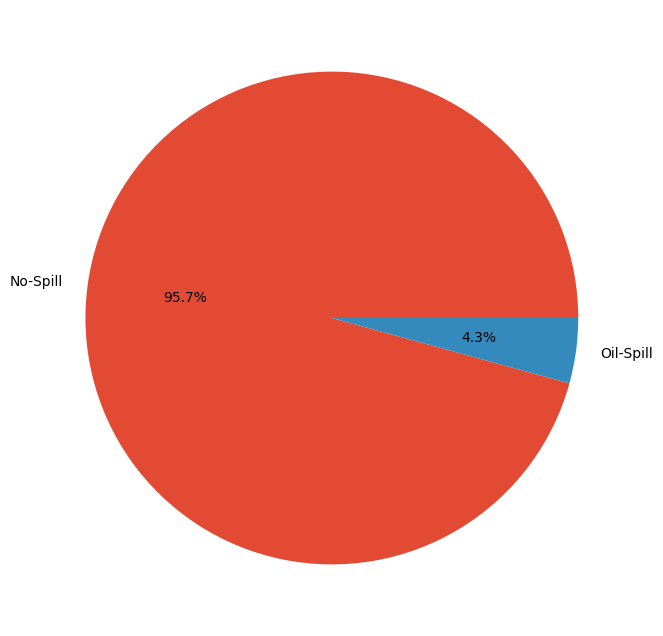

In [21]:
data.duplicated().any()
data.isnull().sum().any()

inter=data['target'].value_counts()
plt.pie(inter,labels=['No-Spill','Oil-Spill'],autopct='%0.1f%%',radius=1);


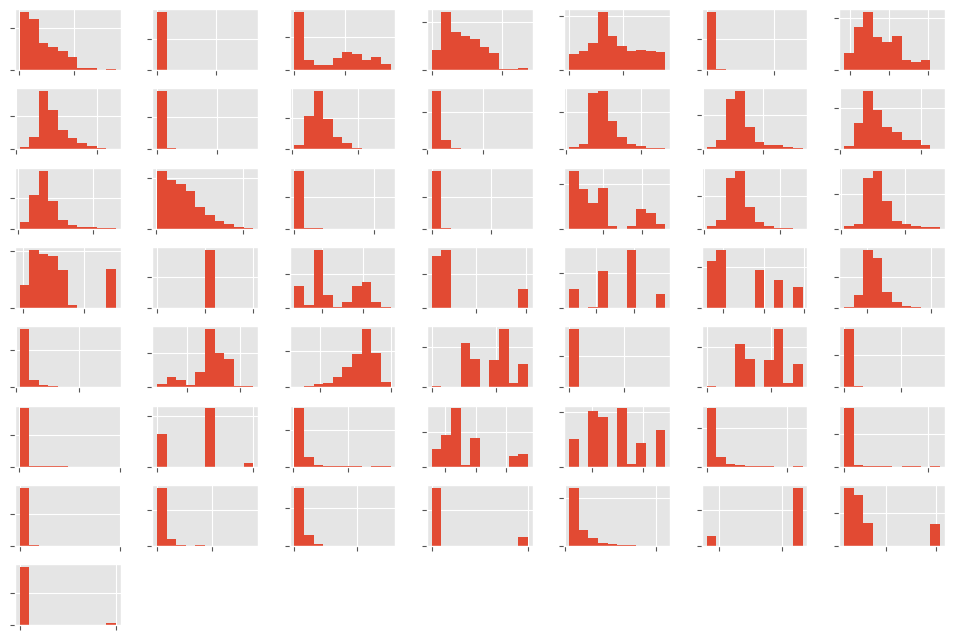

In [22]:
ax = data.hist()

for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])

In [23]:
data.drop(['f_1','f_23'], axis=1, inplace=True)

X=data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [24]:
def evaluate_model(X, y, model):

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(geometric_mean_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores
model = DummyClassifier(strategy='uniform')
scores = evaluate_model(X_train, y_train, model)

print('Mean G-Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean G-Mean: 0.403 (0.227)


In [25]:
def get_models():

    models, names = list(), list()

    steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))]
    models.append(Pipeline(steps=steps))
    names.append('LR')

    steps = [('t', StandardScaler()),('m',LinearDiscriminantAnalysis())]
    models.append(Pipeline(steps=steps))
    names.append('LDA')

    models.append(GaussianNB())
    names.append('NB')

    models.append(RandomForestClassifier())
    names.append('RFC')

    models.append(XGBClassifier())
    names.append('XGB')

    models.append(LGBMClassifier())
    names.append('lGB')

    return models, names
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))


>LR 0.636 (0.249)
>LDA 0.736 (0.206)
>NB 0.692 (0.244)
>RFC 0.303 (0.310)
>XGB 0.536 (0.259)
>lGB 0.492 (0.288)


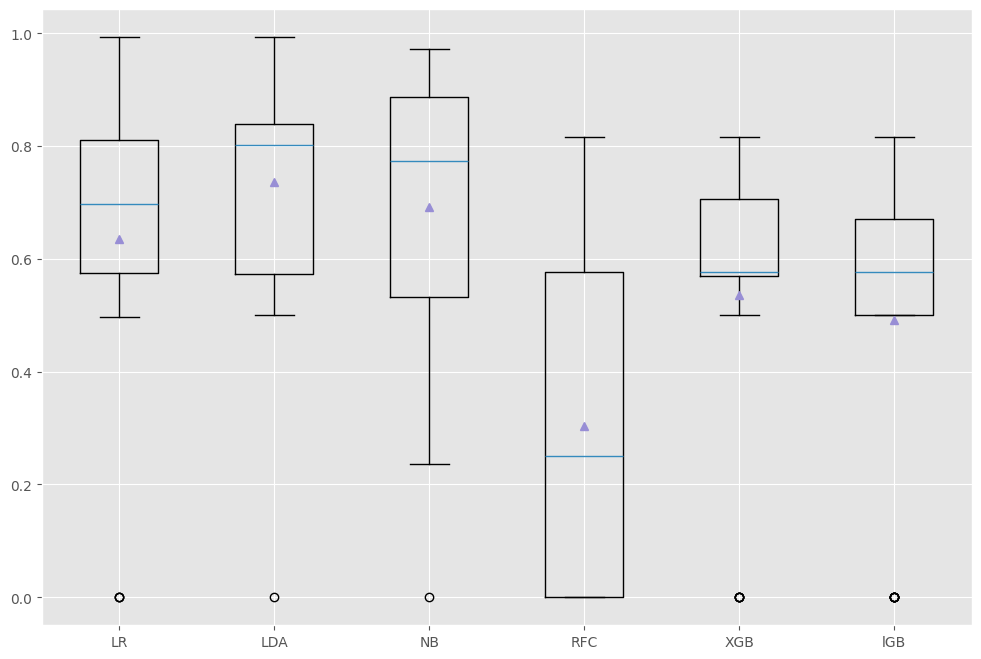

In [26]:
plt.boxplot(results, labels=names, showmeans=True);

In [27]:
def get_models():

    models, names = list(), list()

    # LR Balanced
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
    names.append('Balanced')

    # LR Balanced + Normalization
    steps = [('t',MinMaxScaler()), ('m', LogisticRegression(solver='liblinear',
                                                            class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Norm')

    # LR Balanced + Standardization
    steps = [('t',StandardScaler()), ('m', LogisticRegression(solver='liblinear',
                                                              class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Std')

    # LR Balanced + Power
    steps = [('t1',MinMaxScaler()), ('t2',PowerTransformer()), ('m',
                                                                LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Power')

    return models, names
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)

    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))


>Balanced 0.825 (0.144)
>Balanced-Norm 0.815 (0.137)
>Balanced-Std 0.833 (0.141)
>Balanced-Power 0.797 (0.208)


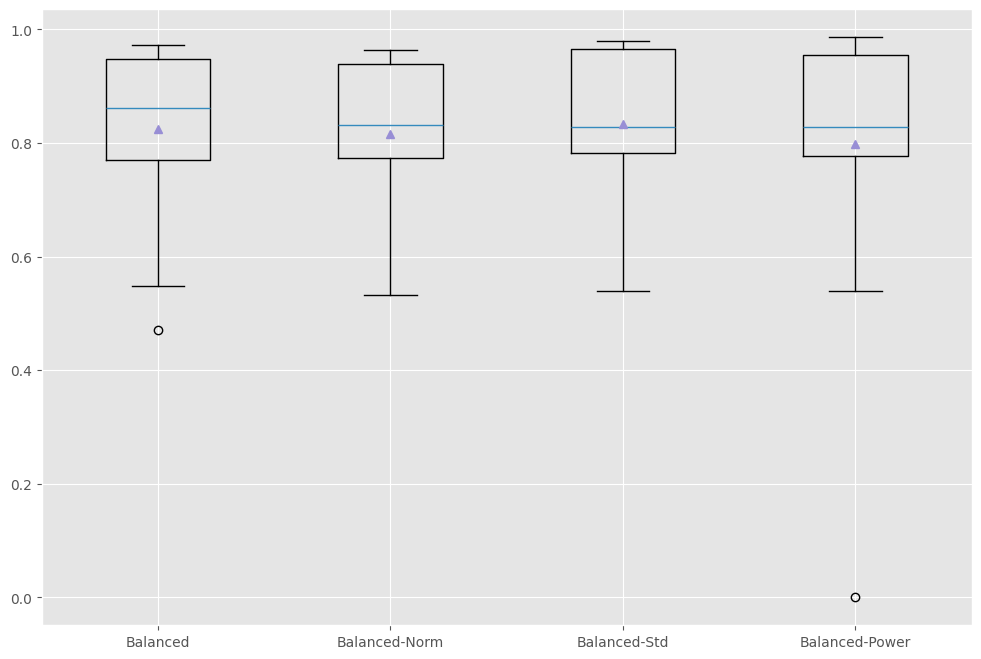

In [28]:
plt.boxplot(results, labels=names, showmeans=True);

In [29]:
def get_models():

    models, names = list(), list()

    # SMOTEENN
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('LR')

    # SMOTEENN + Norm
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', MinMaxScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Norm')

    # SMOTEENN + Std
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', StandardScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Std')

    # SMOTEENN + Power
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m',
                                                                                   model)]
    models.append(Pipeline(steps=steps))
    names.append('Power')

    return models, names
models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)

    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))


>LR 0.863 (0.120)
>Norm 0.818 (0.134)
>Std 0.831 (0.146)
>Power 0.841 (0.141)


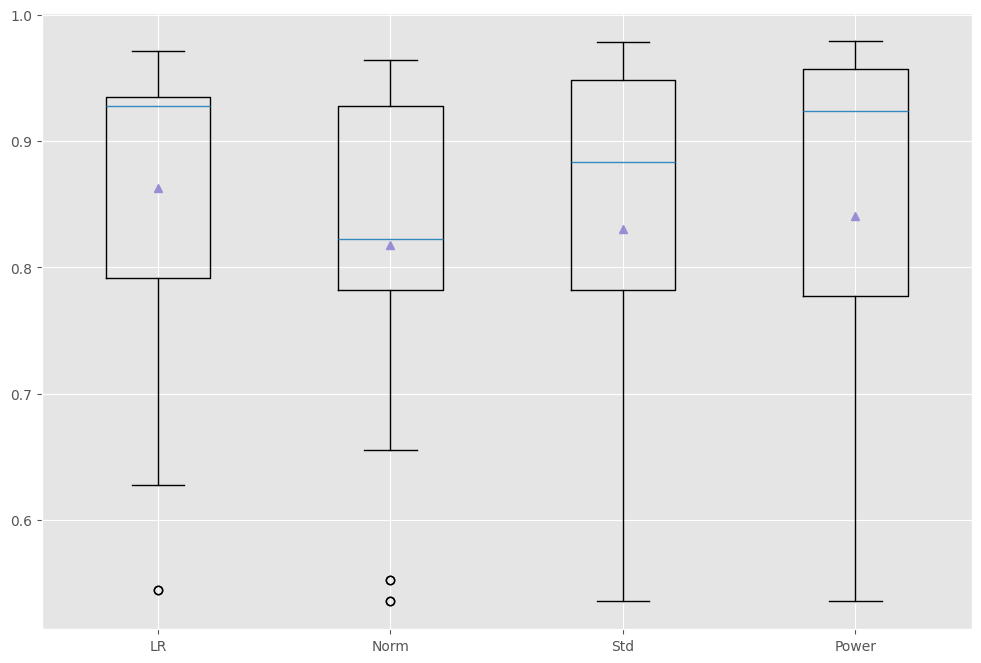

In [30]:
plt.boxplot(results, labels=names, showmeans=True);

In [37]:
smoteenn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear')
pipeline = Pipeline(steps=[('e', smoteenn), ('m', model)])
pipeline.fit(X_train, y_train)
y_pred=pipeline .predict(X_test)

In [33]:
print(f'Classification_report: \n\n {classification_report(y_test,y_pred)}')

Classification_report: 

               precision    recall  f1-score   support

           0       0.99      0.89      0.94       180
           1       0.23      0.75      0.35         8

    accuracy                           0.88       188
   macro avg       0.61      0.82      0.64       188
weighted avg       0.96      0.88      0.91       188



In [34]:
val=['No-Spill','Oil Spill']
data=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=val,index=val)

Text(70.72222222222221, 0.5, 'True Label')

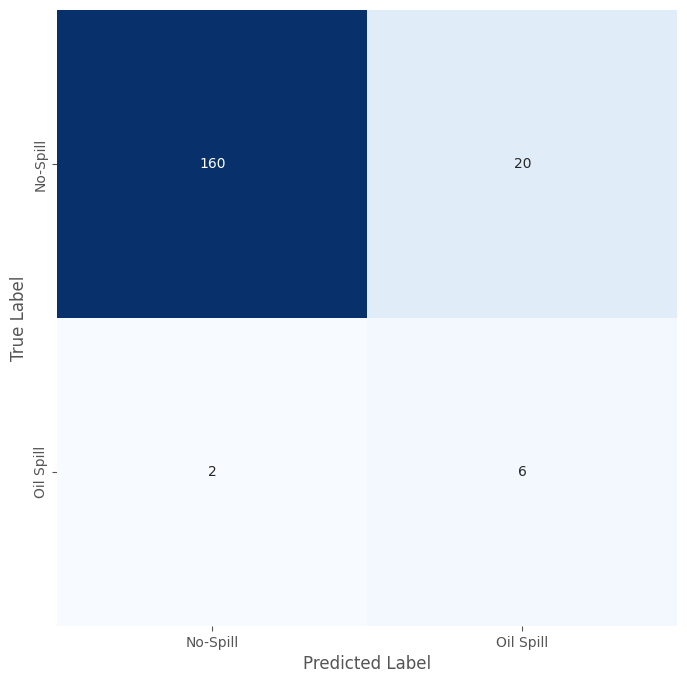

In [35]:
plt.figure(figsize=(8,8))

sns.heatmap(data,annot=True,cbar=False,cmap='Blues',fmt='g');
plt.xlabel('Predicted Label')
plt.ylabel('True Label')